In [1]:
import pandas as pd 
import numpy as np

In [2]:
data = pd.read_csv('C:/Users/bhatt/OneDrive/Desktop/whisper-main/Titanic_Dataset/train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
cols_dropped = ['PassengerId', 'Name', 'Ticket', 'Cabin']

In [5]:
data = data.drop(cols_dropped, axis = 1)

In [6]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
label_enc = LabelEncoder()

In [9]:
data['Sex'] = label_enc.fit_transform(data['Sex'])
data['Embarked'] = label_enc.fit_transform(data['Embarked'])

In [10]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


In [11]:
data.isna().sum()
data['Age'] = data['Age'].fillna(data['Age'].mean())

In [12]:
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [13]:
Y_data = data['Survived']
X_data = data

In [14]:
X_data = X_data.drop(['Survived'], axis = 1)

In [15]:
X_data.shape, Y_data.shape

((891, 7), (891,))

In [16]:
def entropy(col):
    favour = np.unique(col, return_counts = True)
    total = col.shape[0]
    ent = 0
    
    for i in favour[1]:
        prob = i/total
        ent = -1 * (prob * np.log2(prob))
    return ent

In [17]:
# a = [0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0]
# print(np.unique(a, return_counts=True))

In [18]:
def divide_data(X_data, feat, threshold):
    X_right = pd.DataFrame([], columns = X_data.columns)
    X_left = pd.DataFrame([], columns = X_data.columns)
    
    for i in range(X_data.shape[0]):
        value = X_data[feat].loc[i]
        
        if value >= threshold:
            X_right = pd.concat([X_right, X_data.iloc[i : i + 1]])
        else:
            X_left = pd.concat([X_left, X_data.iloc[i : i + 1]])
    return X_left, X_right

In [19]:
left, right = divide_data(X_data[:10], 'Sex', 0.5)

In [20]:
print(left)

  Pclass Sex   Age SibSp Parch     Fare Embarked
1      1   0  38.0     1     0  71.2833        0
2      3   0  26.0     0     0   7.9250        2
3      1   0  35.0     1     0  53.1000        2
8      3   0  27.0     0     2  11.1333        2
9      2   0  14.0     1     0  30.0708        0


In [21]:
print(right)

  Pclass Sex        Age SibSp Parch     Fare Embarked
0      3   1  22.000000     1     0   7.2500        2
4      3   1  35.000000     0     0   8.0500        2
5      3   1  29.699118     0     0   8.4583        1
6      1   1  54.000000     0     0  51.8625        2
7      3   1   2.000000     3     1  21.0750        2


In [22]:
def info_gain(X_data, feat, threshold):
    left, right = divide_data(X_data, feat, threshold)
    
    rho_l = left.shape[0]/X_data.shape[0]
    rho_r = right.shape[0]/X_data.shape[0]
    
    i_gain = entropy(X_data.Survived) - (rho_l * entropy(left.Survived) +
                                        rho_r * entropy(right.Survived))
    return i_gain

In [23]:
for i in X_data.columns:
    print(i, info_gain(data, i, data[i].mean()))

Pclass 0.04617608211243701
Sex 0.12356339465830057
Age 0.0007118844927084256
SibSp 0.005769552253378718
Parch 0.009040300852152572
Fare 0.023967211352379336
Embarked 0.009426992708886694


In [24]:
class Decision_trees:
    
    def __init__(self, max_depth = 10, cur_depth = 0):
        self.left = None
        self.right = None
        self.feat = None
        self.value = None
        self.depth = cur_depth
        self.max_depth = max_depth
        self.target = None
        
    def train_dt(self, X_data):
        f = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
        i_gain = []
        
        for i in f:
            i_gain.append(info_gain(X_data, i, X_data[i].mean()))
        self.feat = f[np.argmax(i_gain)]
        
        self.value = X_data[self.feat].mean()
        
        left, right = divide_data(X_data, self.feat, self.value)
        left = left.reset_index(drop = True)
        right = right.reset_index(drop = True)
        
        print('Making a node with feature:', self.feat)
        
        if left.shape[0] == 0 or right.shape[0] == 0:
            if X_data.Survived.mean() >= 0.5:
                self.target = 'Survived'
            else:
                self.target = 'Not Survived'
            return
        
        if self.depth >= self.max_depth:
            if X_data.Survived.mean() >= 0.5:
                self.target = 'Survived'
            else:
                self.target = 'Not Survived'
            return
        
        self.left = Decision_trees(cur_depth = self.depth + 1)
        self.left.train_dt(left)
        
        self.right = Decision_trees(cur_depth = self.depth + 1)
        self.right.train_dt(right)
        
        return
    
    def predict(self, test):
        if test[self.feat] >= self.value:
            if self.right is None:
                return self.target
            else:
                return self.right.predict(test)
        else:
            if self.left is None:
                return self.target
            else:
                return self.left.predict(test)

In [25]:
split = 0.8

train_X = data[:int(split * data.shape[0])]
test_X = data[int(split * data.shape[0]):]

In [26]:
d_t = Decision_trees()
d_t.train_dt(train_X)

Making a node with feature: Sex
Making a node with feature: Pclass
Making a node with feature: Embarked
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: SibSp
Making a node with feature: Fare
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: SibSp
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Parch
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a 

Making a node with feature: Pclass
Making a node with feature: SibSp
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Fare
Making a node with feature: Fare
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Age
Making a node with feature: SibSp
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Age
Making a node with feature: Age
Making a node with feature: Pclass
Making a node with feature: Pclass
Making a node with feature: Age
Making a node with feature: Age
Making a node with featu

In [27]:
test_X = test_X.reset_index(drop = True)

In [28]:
print(d_t.feat)
print(d_t.left.feat, d_t.right.feat)
print(d_t.left.left.feat, d_t.right.right.feat)
print(d_t.left.right.left.right.left.right.feat)

Sex
Pclass Fare
Embarked SibSp
Parch


In [29]:
pred = []

for i in range(test_X.shape[0]):
    output = d_t.predict(test_X.loc[i])
    if output == 'Not Survived':
        pred.append(0)
    else:
        pred.append(1)

In [30]:
corr = 0
for i in range(len(pred)):
    if pred[i] == test_X['Survived'][i]:
        corr += 1
    else:
        pass
print(corr/test_X.shape[0])

0.8379888268156425


In [31]:
test_X

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,1,48.000000,1,0,52.0000,2
1,0,3,1,29.000000,0,0,9.4833,2
2,0,2,1,52.000000,0,0,13.0000,2
3,0,3,1,19.000000,0,0,7.6500,2
4,1,1,0,38.000000,0,0,227.5250,0
...,...,...,...,...,...,...,...,...
174,0,2,1,27.000000,0,0,13.0000,2
175,1,1,0,19.000000,0,0,30.0000,2
176,0,3,0,29.699118,1,2,23.4500,2
177,1,1,1,26.000000,0,0,30.0000,0


In [32]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)

In [35]:
tree.fit(X_data, Y_data)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [36]:
tree.score(X_data, Y_data)

0.8720538720538721

In [37]:
inp_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
tree.score(test_X[inp_cols], test_X['Survived'])

0.8770949720670391

In [39]:
import matplotlib.pyplot as plt
import sklearn

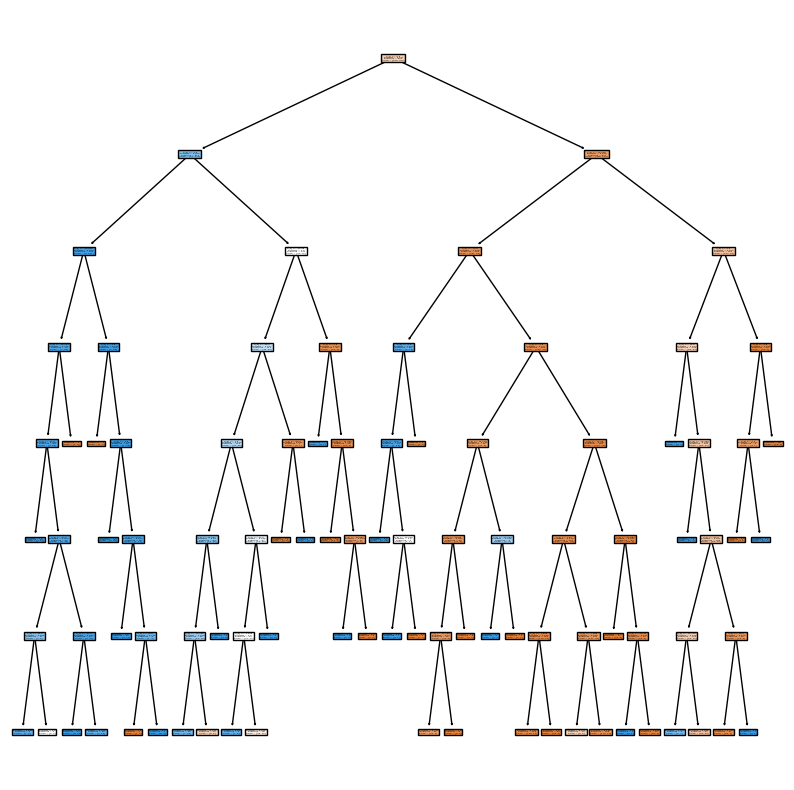

In [40]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (10, 10))
sklearn.tree.plot_tree(tree, filled = True)
plt.savefig('tree.png')

In [45]:
test_X[inp_cols]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,48.000000,1,0,52.0000,2
1,3,1,29.000000,0,0,9.4833,2
2,2,1,52.000000,0,0,13.0000,2
3,3,1,19.000000,0,0,7.6500,2
4,1,0,38.000000,0,0,227.5250,0
...,...,...,...,...,...,...,...
174,2,1,27.000000,0,0,13.0000,2
175,1,0,19.000000,0,0,30.0000,2
176,3,0,29.699118,1,2,23.4500,2
177,1,1,26.000000,0,0,30.0000,0


In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', max_depth = 7)

In [48]:
rf.fit(X_data, Y_data)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=5)

In [49]:
rf.score(test_X[inp_cols], test_X['Survived'])

0.8938547486033519

In [50]:
rf.score(X_data, Y_data)

0.877665544332211

In [58]:
for i in range(1, 100):
    rf = RandomForestClassifier(n_estimators = i, criterion = 'entropy', max_depth = 12)
    rf.fit(X_data, Y_data)
    print(i, rf.score(test_X[inp_cols], test_X['Survived']))

1 0.8994413407821229
2 0.9162011173184358
3 0.8938547486033519
4 0.9162011173184358
5 0.9385474860335196
6 0.9497206703910615
7 0.9441340782122905
8 0.9553072625698324
9 0.9664804469273743
10 0.9497206703910615
11 0.9608938547486033
12 0.9776536312849162
13 0.9664804469273743
14 0.9441340782122905
15 0.9608938547486033
16 0.9553072625698324
17 0.9608938547486033
18 0.9720670391061452
19 0.9608938547486033
20 0.9776536312849162
21 0.9497206703910615
22 0.9664804469273743
23 0.9720670391061452
24 0.9553072625698324
25 0.9553072625698324
26 0.9608938547486033
27 0.9776536312849162
28 0.9664804469273743
29 0.9608938547486033
30 0.9497206703910615
31 0.9720670391061452
32 0.9608938547486033
33 0.9720670391061452
34 0.9608938547486033
35 0.9664804469273743
36 0.9720670391061452
37 0.9664804469273743
38 0.9664804469273743
39 0.9664804469273743
40 0.9664804469273743
41 0.9776536312849162
42 0.9664804469273743
43 0.9720670391061452
44 0.9664804469273743
45 0.9720670391061452
46 0.97206703910614